In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
import random
from Helper.ImportDatasets import df_epsilon, df_epsilon_crit
from Method.calculate_distribution_a import distribution_a

# Introduction
In this notebook we calculate the distribution of a for different networks multiple times. Then we check if this makes sense.

We do this by taking all the actual critical epsilons and checking how many are lower than the calculated aread, in the area, and above it.

In [3]:
"""
We pick sigma, delta, network and number of samples. Although delta doesn't matter much as the region of a we use is large enough to quickly find a solution where prob = 1
"""
def run(network, ani = False, shuffle = False, step_size_a = 0.001, sigma = 0.05, n_samples = 1000, n_a_samples = 100, uncertainty = 0.02):
    delta = 0.05
    
    # Get the network and test set, then split the images
    df_for_network = df_epsilon[df_epsilon['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]
    
    # We find the distribution of 'a' for the following bins, number represents left side of bin
    a = torch.arange(step_size_a,0.4,step_size_a)
    
    # We keep track of the distributions of 'a' and its max probability
    distributions_of_a = []
    
    # We keep track of what bins of 'a' we use
    a_bins = []
    
    # Initialize D (dataset) and the default value to put in if we don't find elligible epsilons
    D = torch.tensor([[],[]],dtype=torch.float32)
    default = torch.tensor([[0],[0.4]],dtype=torch.float32)
    
    if shuffle:
        random.shuffle(df_per_image)
    
    for i,image in enumerate(df_per_image):
        # We put in the default value first and then change it to the lower and upper bound of the image
        D = torch.cat((D,default),dim=1)
        
        # unsat means epsilon >, thus lower bound
        lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values)
        # sat means epsilon <, thus upper bound
        upper_bound = np.min(image[image['result']=='sat']['epsilon'].values)
        D[0,-1] = lower_bound
        D[1,-1] = upper_bound
        
        print(f"image {i+1}")
        
        # Sample in our bins of 'a', 100 samples are taken per bin
        a_samples = torch.rand(n_a_samples,*a.shape)*step_size_a+a
        # We calculate the distribution of each sample
        distr = distribution_a(a_samples,D,sigma,n_samples)
        max_distr = torch.max(distr)
        distributions_of_a.append(distr)
        a_bins.append(a)
        
        # If the distribution of 'a' becomes too peaked to fit in the range of a that has been given we are also satisfied as we know 'a' is in a small enough region
        if torch.isnan(max_distr):
           distributions_of_a.pop()
           a_bins.pop()
           print('found: region is too small')
           break
        
        # We adapt the area in which we search for 'a' based on the distribution
        indices = torch.where(distr != 0)[0]
        left_bound_ind = torch.min(indices)
        right_bound_ind = torch.max(indices)
        
        # We update the bounds
        left_bound = a[left_bound_ind]
        right_bound = a[right_bound_ind]
        
        # We check if the required uncertainty has been reached
        if right_bound-left_bound < 2*uncertainty:
            print('found: uncertainty reached')
            break
        
        # We check if we have attained a probability of at least 1-delta
        if max_distr > 1-delta:
            print('found')
            break
        
        # We update the range of 'a' we search in
        step_size_a = (right_bound-left_bound)/400
        a = torch.arange(left_bound,right_bound,step_size_a)
        
    
    if ani:
        fig, ax = plt.subplots()
    
        ax.set_ylim(0, 0.1)
        ax.set_xlim(0,0.2)
        line, = ax.plot(a, np.tile(0,len(a)))
        
        
        def animate(i):
            line.set_ydata(distributions_of_a[i])  # update the data.
            line.set_xdata(a_bins[i])
            return line,
        
        
        ani = animation.FuncAnimation(
            fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)
        
        # To save the animation, use e.g.
        #
        ani.save(network+".gif")
    
    return distributions_of_a, a_bins

In [4]:
networks = df_epsilon['network'].unique()

image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
found: region is too small


C:\Users\lkiel\AppData\Local\Temp\ipykernel_13860\1014375679.py:94: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=26.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


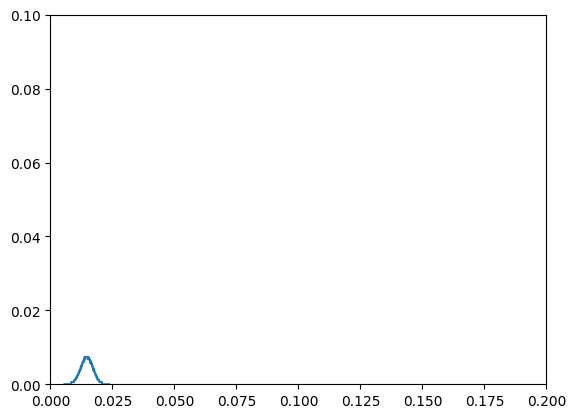

In [6]:
network = networks[0]
distr, a_bins = run(network, uncertainty = 0.002, ani=True)

In [ ]:
# Take all critical epsilons and calculate if they are in the area, below it, or above it
# We ignore that the critical epsilon is an area as it would complicate things for now
df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
df_for_network = df_for_network[df_for_network['ds'] == 'test']
crit_epsilons = df_for_network['Epsilon'].to_numpy()

In [ ]:
Total = crit_epsilons.shape[0]
under = np.sum(crit_epsilons < left_bound.numpy())
over = np.sum(crit_epsilons > right_bound.numpy())
in_between = Total - under - over
print(f"Percentage under: {np.round((under/Total)*100,2)}%, Percentage in between: {np.round((in_between/Total)*100,2)}%, Percentage over: {np.round((over/Total)*100,2)}%")

In [ ]:
def calculate_percentages(distr, a_bins):
    
    indices = torch.where(distr[-1] == 0)[0]
    split_arrays = np.split(indices,torch.where(torch.diff(indices) != 1)[0]+1)
    # Check wether left and right arrays exist
    if len(split_arrays) == 1:
        arr = split_arrays[0]
        if arr.shape[0] == 0:
            left_bound_ind = 0
            right_bound_ind = -1
        elif torch.min(arr) == 0:
            left_bound_ind = torch.max(arr)
            right_bound_ind = -1
        else:
            left_bound_ind = 0
            right_bound_ind = torch.min(arr)
    elif len(split_arrays) == 2:
        left_bound_ind = torch.max(split_arrays[0])
        right_bound_ind = torch.min(split_arrays[1])
    else:
        print('error? 2')
        print(split_arrays)
        left_bound_ind = torch.max(split_arrays[0])
        right_bound_ind = torch.min(split_arrays[-1])
    
    # We update the bounds
    left_bound = a_bins[-1][left_bound_ind]
    right_bound = a_bins[-1][right_bound_ind]
    
    # Take all critical epsilons and calculate if they are in the area, below it, or above it
    # We ignore that the critical epsilon is an area as it would complicate things for now
    df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    crit_epsilons = df_for_network['Epsilon'].to_numpy()
    
    Total = crit_epsilons.shape[0]
    under = np.sum(crit_epsilons < left_bound.numpy())
    over = np.sum(crit_epsilons > right_bound.numpy())
    in_between = Total - under - over
    print(f"Percentage under: {np.round((under/Total)*100,2)}%, Percentage in between: {np.round((in_between/Total)*100,2)}%, Percentage over: {np.round((over/Total)*100,2)}%")
    return np.round((under/Total)*100,2), np.round((in_between/Total)*100,2), np.round((over/Total)*100,2)

# Implementation

In [ ]:
network = networks[0]
distr, a_bins = run(network, uncertainty = 0.02, ani=False)
calculate_percentages(distr, a_bins)

In [ ]:
network = networks[0]
distr, a_bins = run(network, uncertainty = 0.002, ani=False)
calculate_percentages(distr, a_bins)

In [65]:
network = networks[0]
final_distr = []
final_bins = []
percentages = []
for i in range(10):
    distr, bins = run(network, ani=False, shuffle = True, uncertainty= 0.002)
    temp_distr = distr[-1].numpy()
    temp_bins = bins[-1].numpy()
    final_distr.append(temp_distr)
    final_bins.append(temp_bins)
    percentages.append(calculate_percentages(distr, bins))
    print(f"{i+1}/10 done")

image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
error? 2
[tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 13

In [66]:
network = networks[-1]
final_distr = []
final_bins = []
percentages = []
for i in range(10):
    distr, bins = run(network, ani=False, shuffle = True, uncertainty= 0.002)
    temp_distr = distr[-1].numpy()
    temp_bins = bins[-1].numpy()
    final_distr.append(temp_distr)
    final_bins.append(temp_bins)
    percentages.append(calculate_percentages(distr, bins))
    print(f"{i+1}/10 done")

image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
found: region is too small
Percentage under: 6.19%, Percentage in between: 19.59%, Percentage over: 74.23%
1/10 done
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
found: region is too small
Percentage under: 6.19%, Percentage in between: 13.4%, Percentage over: 80.41%
2/10 done
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
found: region is too small
Percentage under: 1.03%, Percentage in between: 6.19%, Percentage over: 92.78%
3/10